In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-06-05 09:47:48,470 - matplotlib - DEBUG - matplotlib data path: /cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data
2024-06-05 09:47:48,476 - matplotlib - DEBUG - CONFIGDIR=/cmnfs/home/z.xiao/.config/matplotlib
2024-06-05 09:47:48,478 - matplotlib - DEBUG - interactive is False
2024-06-05 09:47:48,479 - matplotlib - DEBUG - platform is linux
2024-06-05 09:47:48,541 - matplotlib - DEBUG - CACHEDIR=/cmnfs/home/z.xiao/.cache/matplotlib
2024-06-05 09:47:48,547 - matplotlib.font_manager - DEBUG - Using fontManager instance from /cmnfs/home/z.xiao/.cache/matplotlib/fontlist-v330.json


# Load data

In [3]:
from peak_detection_2d.seg_model import UNET
import torch

result_dir = "/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FIRST_OUT_CHANNELS = 32

In [16]:
log_trans_spec_dir = "peak_selection_seg_model_1out32_lr0.05_bs512_comboloss_bce3_dice4_focal1_metric_wdice_log"
log_trans_dir = os.path.join(result_dir, log_trans_spec_dir)
log_trans_model_path = os.path.join(log_trans_dir, "bst_model_0.7212.bin")
log_trans_model = UNET(1, FIRST_OUT_CHANNELS, 1, padding=1, downhill=4).to(DEVICE)
checkpoint = torch.load(log_trans_model_path, map_location=DEVICE)
log_trans_model.load_state_dict(checkpoint)

normal_spec_dir = "peak_selection_seg_model_1out32_lr0.01_bs512_comboloss_bce1_dice4_focal_1_metric_wdice"
normal_dir = os.path.join(result_dir, normal_spec_dir)
normal_model_path = os.path.join(normal_dir, "bst_model_0.751.bin")
normal_model = UNET(1, FIRST_OUT_CHANNELS, 1, padding=1, downhill=4).to(DEVICE)
checkpoint = torch.load(normal_model_path, map_location=DEVICE)
normal_model.load_state_dict(checkpoint)

<All keys matched successfully>

<All keys matched successfully>

In [47]:
from peak_detection_2d.dataset import (
    MultiHDF5_MaskDataset,
    Mask_Padding,
    Mask_ToTensor,
    Mask_LogTransform,
)
from torchvision.transforms import Compose

EVALUATE = True
RANDOM_STATE = 42
BATCH_SIZE = 512
# ================Data set===============#
hdf5_files = [
    os.path.join(
        os.path.join(result_dir, "peak_detection_mask_data_rt_full_overlap"), file
    )
    for file in os.listdir(
        os.path.join(result_dir, "peak_detection_mask_data_rt_full_overlap")
    )
    if file.endswith(".h5")
]

# Define transformations (if any)
transformation_log = Compose(
    [Mask_Padding((178, 178)), Mask_LogTransform(), Mask_ToTensor()]
)
transformation = Compose([Mask_Padding((178, 178)), Mask_ToTensor()])

In [48]:
# Create the dataset
dataset = MultiHDF5_MaskDataset(hdf5_files, transforms=transformation)

# Split the dataset into training and testing sets
train_val_dataset, test_dataset = dataset.split_dataset(
    train_ratio=0.9, seed=RANDOM_STATE
)
train_dataset, val_dataset = train_val_dataset.split_dataset(
    train_ratio=0.9, seed=RANDOM_STATE
)

# Example usage
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False
)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False
)
logging.info("Train dataset size: %d", len(train_dataset))
logging.info("Validation dataset size: %d", len(val_dataset))
logging.info("Test dataset size: %d", len(test_dataset))

2024-06-05 11:43:41,850 - root - INFO - Train dataset size: 26379
2024-06-05 11:43:41,851 - root - INFO - Validation dataset size: 2931
2024-06-05 11:43:41,851 - root - INFO - Test dataset size: 3257


In [60]:
ind_all_wiou_log.loc[ind_all_wiou_log["losses"] > 0.5, "losses"].mean()

0.811348683869509

In [19]:
%autoreload 2
reload(logging)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
if EVALUATE:
    from peak_detection_2d.seg_model import evaluate
    from peak_detection_2d.loss import dice_metric, per_image_dice_metric, per_image_weighted_dice_metric, per_image_weighted_iou_metric
#     # Batch loss
#     avg_loss, all_losses = evaluate(
#         model=bst_model, valid_loader=test_dataloader, device=DEVICE, metric=dice_metric, save_all_loss=True
#     )
    # Individual weighted dice
#     ind_avg_wdice, ind_all_wdice = evaluate(
#     model=log_trans_model, valid_loader=test_dataloader, device=DEVICE, metric=per_image_weighted_dice_metric, save_all_loss=True, use_image_for_metric = True
# )
    # Individual weighted iou
    ind_avg_wiou, ind_all_wiou_normal = evaluate(
    model=normal_model, valid_loader=test_dataloader, device=DEVICE, metric=per_image_weighted_iou_metric, save_all_loss=True, use_image_for_metric = True)

<module 'logging' from '/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/logging/__init__.py'>

  0%|          | 0/51 [00:00<?, ?it/s]

2024-06-05 09:53:46,806 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-05 09:53:46,807 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([64, 1, 178, 178])
2024-06-05 09:53:46,809 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([64, 32, 178, 178])
2024-06-05 09:53:46,810 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, paddi

In [49]:
# Create the dataset
dataset_log = MultiHDF5_MaskDataset(hdf5_files, transforms=transformation_log)

# Split the dataset into training and testing sets
train_val_dataset_log, test_dataset_log = dataset_log.split_dataset(
    train_ratio=0.9, seed=RANDOM_STATE
)
train_dataset_log, val_dataset_log = train_val_dataset_log.split_dataset(
    train_ratio=0.9, seed=RANDOM_STATE
)

# Example usage
train_dataloader = torch.utils.data.DataLoader(
    train_dataset_log, batch_size=BATCH_SIZE, shuffle=False
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset_log, batch_size=512, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset_log, batch_size=64, shuffle=False
)

In [21]:
ind_avg_wiou, ind_all_wiou_log = evaluate(
    model=log_trans_model,
    valid_loader=test_dataloader,
    device=DEVICE,
    metric=per_image_weighted_iou_metric,
    save_all_loss=True,
    use_image_for_metric=True,
)

  0%|          | 0/51 [00:00<?, ?it/s]

2024-06-05 09:54:16,843 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-05 09:54:16,845 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([64, 1, 178, 178])
2024-06-05 09:54:16,846 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([64, 32, 178, 178])
2024-06-05 09:54:16,846 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, paddi

In [22]:
from peak_detection_2d.utils import plot_sample_predictions
import pandas as pd

ind_all_wiou_log = pd.DataFrame(ind_all_wiou_log)
# get indices of the top 10 worst performing images
worst_performing_images_log = ind_all_wiou_log.loc[ind_all_wiou_log["losses"] < 0.01]

In [23]:
ind_all_wiou_normal = pd.DataFrame(ind_all_wiou_normal)
# get indices of the top 10 worst performing images
worst_performing_images_normal = ind_all_wiou_normal.loc[
    ind_all_wiou_normal["losses"] < 0.01
]

In [31]:
ind_all = pd.merge(
    left=ind_all_wiou_log,
    right=ind_all_wiou_normal,
    on="ranks",
    how="outer",
    suffixes=("_log", "_normal"),
    indicator=True,
)

In [45]:
import plotly.express as px

px.scatter(ind_all, x="losses_normal", y="losses_log", hover_name="ranks")

2024-06-05 11:53:07,728 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-05 11:53:07,730 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 1, 178, 178])
2024-06-05 11:53:07,731 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 178, 178])
2024-06-05 11:53:07,732 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding

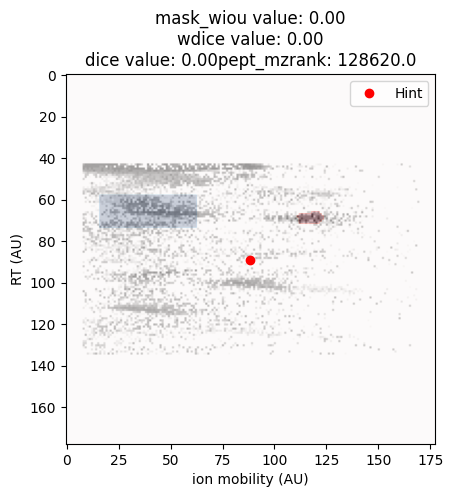

2024-06-05 11:53:08,103 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-05 11:53:08,103 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 1, 178, 178])
2024-06-05 11:53:08,105 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 178, 178])
2024-06-05 11:53:08,105 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding

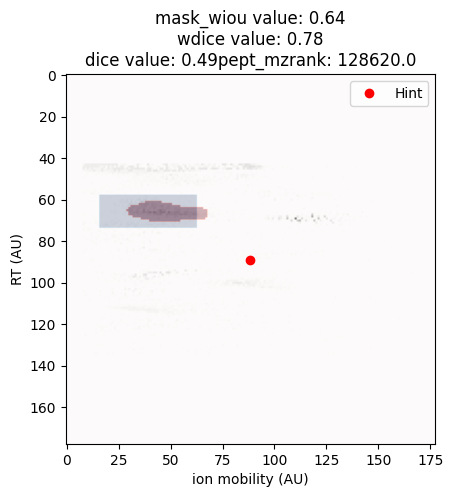

In [56]:
testset_idx = ind_all.loc[ind_all["ranks"] == 128620].index[0]
# Plot sample predictions
plot_sample_predictions(
    test_dataset_log,
    model=log_trans_model,
    sample_indices=[testset_idx],
    # n = 10,
    save_dir=None,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    device=DEVICE,
    # save_dir=os.path.join(log_trans_dir, "sample_predictions_highest_wiou"),
)
plot_sample_predictions(
    test_dataset,
    model=normal_model,
    sample_indices=[testset_idx],
    # n = 10,
    save_dir=None,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    device=DEVICE,
    # save_dir=os.path.join(log_trans_dir, "sample_predictions_highest_wiou"),
)

In [11]:
from peak_detection_2d.utils import plot_per_image_metric_distr

plot_per_image_metric_distr(ind_all_wiou_log, "Weighted_IoU", save_dir=log_trans_dir)
plot_per_image_metric_distr(ind_all_wdice, "Weighted_Dice", save_dir=log_trans_dir)

2024-06-03 16:04:07,102 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-03 16:04:07,103 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-03 16:04:07,108 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-06-03 16:04:07,109 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-06-03 16:04:07,109 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='norm

25%: 0.29
50%: 0.72
75%: 0.93


2024-06-03 16:04:08,119 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/opentype/lobstertwo/LobsterTwo-Regular.otf', name='Lobster Two', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-06-03 16:04:08,120 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/unfonts-core/UnPilgiBold.ttf', name='UnPilgi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-06-03 16:04:08,120 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansMendeKikakui-Regular.ttf', name='Noto Sans Mende Kikakui', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-06-03 16:04:08,121 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/adf/UniversalisADFStd-Cond.otf', name='Universalis ADF Std', style='normal', v

25%: 0.44
50%: 0.84
75%: 0.96


In [20]:
import gc

torch.cuda.empty_cache()
gc.collect()

3759

In [20]:
%autoreload 2
from peak_detection_2d.utils import plot_sample_predictions

# Plot sample predictions
plot_sample_predictions(
    test_dataset,
    model=log_trans_model,
    sample_indices=[1420, 2409, 1483, 2101,  68, 3003, 2973, 2182, 2311, 2606],
    #n = 10,
    #save_dir=None,
    metric_list = ["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in = False,
    label = 'mask',
    save_dir=os.path.join(log_trans_dir, "sample_predictions"),
)

2024-06-03 16:25:35,331 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-03 16:25:35,332 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 1, 178, 178])
2024-06-03 16:25:35,333 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 178, 178])
2024-06-03 16:25:35,334 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding